# Intuition

We can have 2 kinds of predictions:

1. Given that the customer has not bought before, 
    1. Can we use their demographics to determine:
        1. How much (dollar amount) they will buy?
        2. How many items they will buy?
        3. What categories they will buy?
2. Given that the customer has made a purchase, 
    1. Can we see if their demographics, purchase history and purchase experience determine the likelihood of them returning?
        1. Compare the non-last transactions of repeat customers against transactions by single-time customers
    2. Can we compare past purchases to future ones? 
        1. E.g. to see if big spenders always spend big for all purchases. 
          Or those that buy from a certain category will continue to buy from that category. 
    3. Can we segment customers based on their purchase history? 
        1. Can also explore if particular segments have higher chance of returning customers. 
    
Can we segment customers based on what they purchase? E.g.:
* Those that purchase huge range of products
* Those that purchase only 1 item

# Import Data

In [200]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pandas_profiling import ProfileReport
from tabulate import tabulate

from IPython.display import display, Markdown

sns.set(rc={'figure.figsize':(14, 6)})

from sklearn.metrics import precision_score, recall_score

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [328]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv").set_index('product_id')
products.product_category_name.fillna('others', inplace=True)
order_items = order_items.join(products, on='product_id').drop(['order_item_id'], axis=1)

for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col])
    
state_data = pd.read_csv("data/brazil_state_data.csv")
state_data.set_index('state', inplace=True)
state_data['gdp_per_capita'] = state_data['gdp'] / state_data['population']
customers = customers.join(state_data, on='customer_state')

orders = orders.merge(customers, on='customer_id').drop('customer_id', axis=1)

* GDP Data: https://agenciadenoticias.ibge.gov.br/en/agencia-press-room/2185-news-agency/releases-en/10155-gdp-of-municipalities-agriculture-represents-more-than-half-of-economic-activity-in-1-135-municipalities
* Population Data: https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product 
* Size Data: http://www.brazil-help.com/brazilian_states.htm

# Data Preparation

In [329]:
orders['time_to_approve'] = (orders.order_approved_at - orders.order_purchase_timestamp).dt.total_seconds()
orders['time_to_ship'] = (orders.order_delivered_carrier_date - orders.order_approved_at).dt.total_seconds()
orders['time_to_reach'] = (orders.order_delivered_customer_date - orders.order_delivered_carrier_date).dt.total_seconds()
orders['days_delivery_diff'] = (orders.order_estimated_delivery_date - orders.order_delivered_customer_date).dt.days
orders['month_purchase'] = orders.order_purchase_timestamp.dt.month

In [330]:
orders['customer_num_order'] = orders.groupby('customer_unique_id')['order_purchase_timestamp'].rank()

In [331]:
max_num_orders = pd.DataFrame(customers.customer_unique_id.value_counts())
max_num_orders.columns = ['max_num_orders']

In [332]:
order_details = order_items.groupby('order_id').agg({'price': ['size', 'sum', 'mean'], 'freight_value': ['sum', 'mean'], 'product_id': ['nunique'], 'seller_id': ['nunique']})
cols = ['_'.join(col) for col in order_details.columns]
cols[0] = 'num_items'
order_details.columns = cols

In [333]:
order_reviews = reviews.groupby('order_id').agg({'review_score': ['size', 'mean']})
order_reviews.columns = ['num_reviews', 'avg_review']

In [334]:
orders = orders.join(max_num_orders, on='customer_unique_id').join(order_details, on='order_id').join(order_reviews, on='order_id')

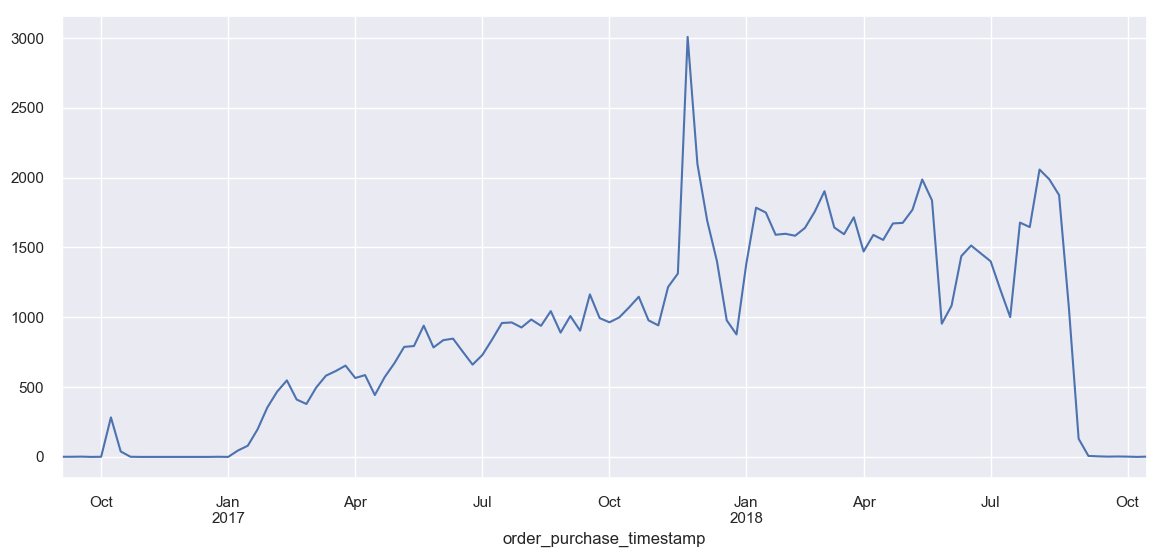

In [335]:
orders[['order_purchase_timestamp']].set_index('order_purchase_timestamp').resample('W').size().plot()

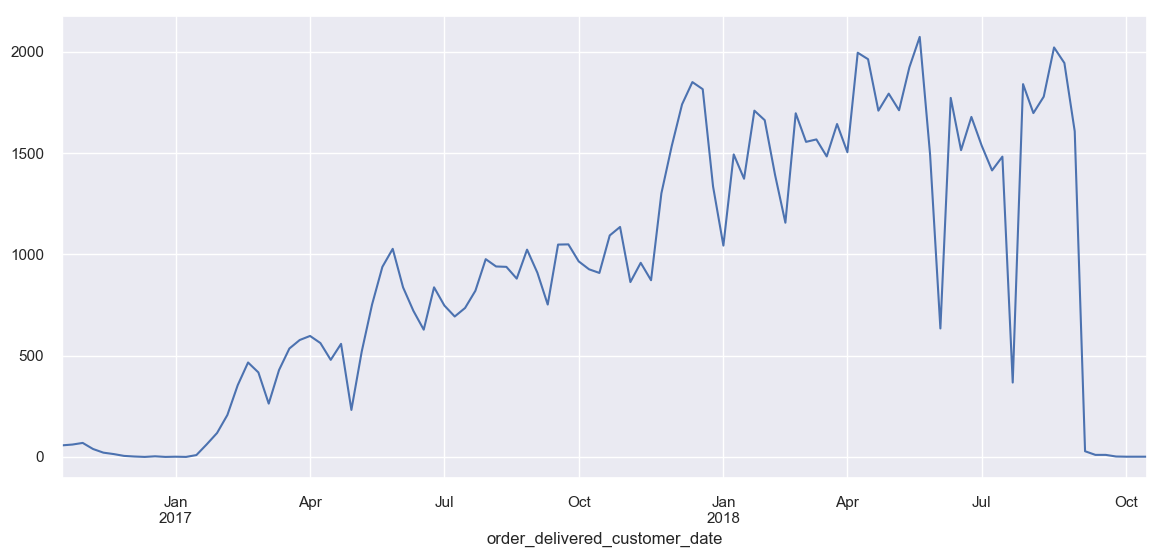

In [187]:
orders[['order_delivered_customer_date']].set_index('order_delivered_customer_date').resample('W').size().plot()

# Analysis

## Analysing All Customers

### Using Demographics to Predict Purchase Volume

In [103]:
orders[['price_sum', 'num_items', 'customer_state', 'gdp', 'size', 'population', 'customer_city', 'customer_zip_code_prefix']].head()

,price_sum,num_items,customer_state,gdp,size,population,customer_city,customer_zip_code_prefix
0,29.99,1.0,SP,628064882,248209,44035304,sao paulo,3149
1,118.70,1.0,BA,56624041,564692,15126371,barreiras,47813
2,159.90,1.0,GO,46094735,340086,6523222,vianopolis,75265
3,45.00,1.0,RN,19076030,52796,3408510,sao goncalo do amarante,59296
4,19.90,1.0,SP,628064882,248209,44035304,santo andre,9195


In [180]:
orders.shape

(99441, 31)

In [179]:
orders.dropna().shape

(96461, 31)

In [203]:
for y_col in ['price_sum', 'num_items', 'seller_id_nunique']:
    display(Markdown("# " + y_col))
    sub = orders[[y_col, 'gdp_per_capita', 'size']].dropna()
    X2 = sm.add_constant(sub.drop(y_col, axis=1))
    X2['gdp_per_capita'] = np.log1p(X2['gdp_per_capita'])
    X2['size'] = np.log1p(X2['size'])
    est = sm.OLS(np.log1p(sub[y_col]), X2)
    est2 = est.fit()
    display(est2.summary())

# price_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     180.5
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           5.43e-79
Time:                        19:47:05   Log-Likelihood:            -1.3146e+05
No. Observations:               98666   AIC:                         2.629e+05
Df Residuals:                   98663   BIC:                         2.629e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3417      0.052    102.081      0.000       5.239       5.444
gdp_per_capita    -0.1076      0.006    -18.230      0.000      -0.119      -0.096
size              -0.0513      0.004    -14.440      0.000      -0.058      -0.044
==============================================================================
Omnibus:                     1648.995   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1825.848
Skew:                           0.287   Prob(JB):                         0.00
Kurtosis:                       3.340   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# num_items

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_items   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.094
Date:                Sun, 21 Apr 2019   Prob (F-statistic):            0.00613
Time:                        19:47:05   Log-Likelihood:                 36477.
No. Observations:               98666   AIC:                        -7.295e+04
Df Residuals:                   98663   BIC:                        -7.292e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7157      0.010     75.021      0.000       0.697       0.734
gdp_per_capita     0.0032      0.001      2.975      0.003       0.001       0.005
size               0.0017      0.001      2.592      0.010       0.000       0.003
==============================================================================
Omnibus:                    80958.272   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1804788.576
Skew:                           3.975   Prob(JB):                         0.00
Kurtosis:                      22.386   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# seller_id_nunique

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.843
Date:                Sun, 21 Apr 2019   Prob (F-statistic):             0.0214
Time:                        19:47:05   Log-Likelihood:             1.5938e+05
No. Observations:               98666   AIC:                        -3.188e+05
Df Residuals:                   98663   BIC:                        -3.187e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6910      0.003    251.733      0.000       0.686       0.696
gdp_per_capita     0.0005      0.000      1.774      0.076   -5.76e-05       0.001
size               0.0005      0.000      2.753      0.006       0.000       0.001
==============================================================================
Omnibus:                   143547.669   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33362668.484
Skew:                           9.143   Prob(JB):                         0.00
Kurtosis:                      91.210   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using Demographics to Predict Purchase Items

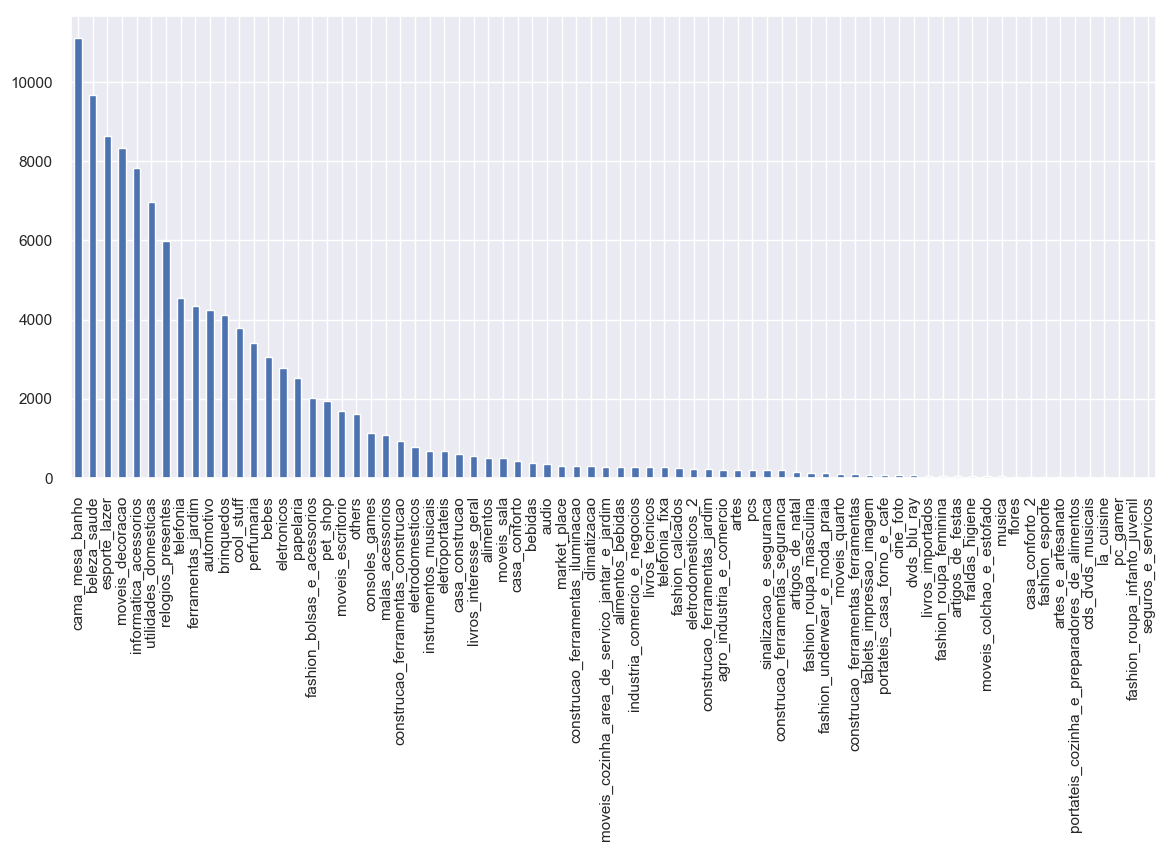

In [336]:
order_items.product_category_name.value_counts().plot(kind='bar')

In [399]:
first_n = 25
percent = order_items.product_category_name.value_counts()[:first_n].sum() / order_items.shape[0] * 100
display(Markdown("The first {} categories account for {:.2f}% of all orders. Let's convert the rest to \"others\".".format(first_n, percent)))

The first 25 categories account for 91.64% of all orders. Let's convert the rest to "others".

In [400]:
categories = pd.DataFrame(order_items.product_category_name.value_counts())
categories['product_category_name'] = categories.index
categories[first_n:]['product_category_name'] = 'others'

C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [402]:
if 'product_category' in order_items.columns:
    order_items.drop('product_category', axis=1, inplace=True)
categories.columns = ['product_category']
order_items = order_items.join(categories, on='product_category_name')

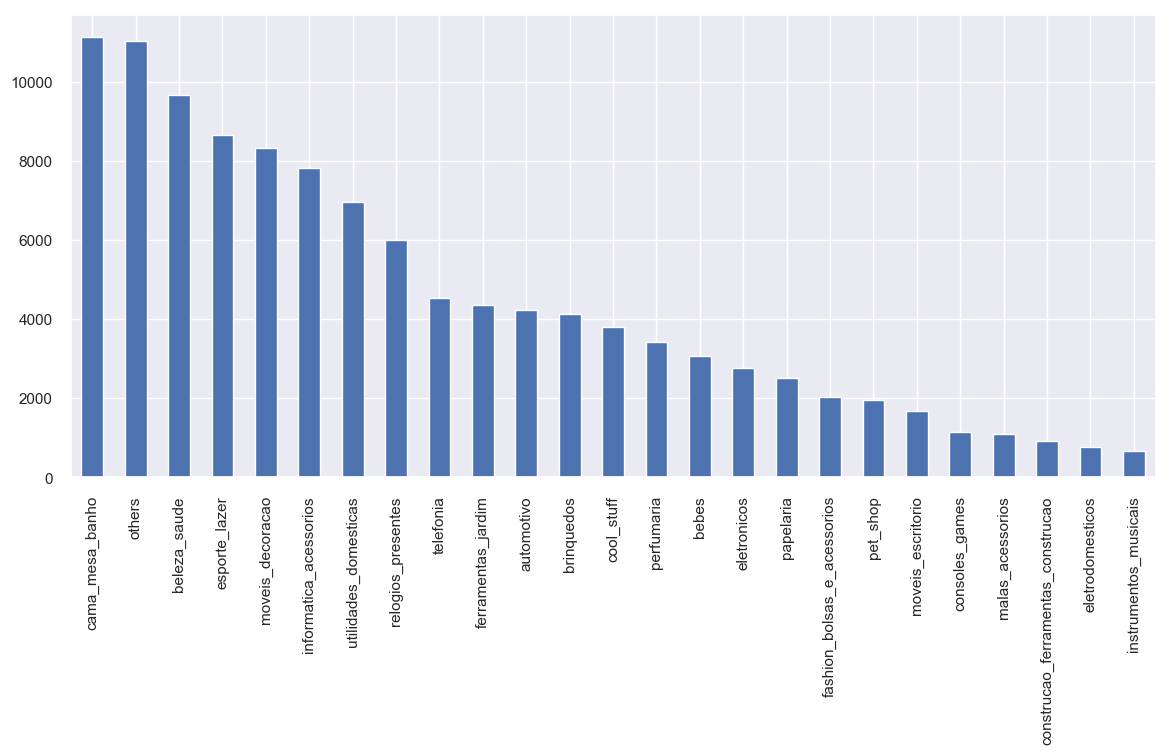

In [403]:
order_items.product_category.value_counts().plot(kind='bar')

In [404]:
subset = orders[['order_id', 'gdp_per_capita', 'gdp', 'population', 'size']].join(order_items.set_index('order_id'), on='order_id', how='right')[['product_category', 'gdp_per_capita', 'gdp', 'population', 'size']]

# gdp_per_capita

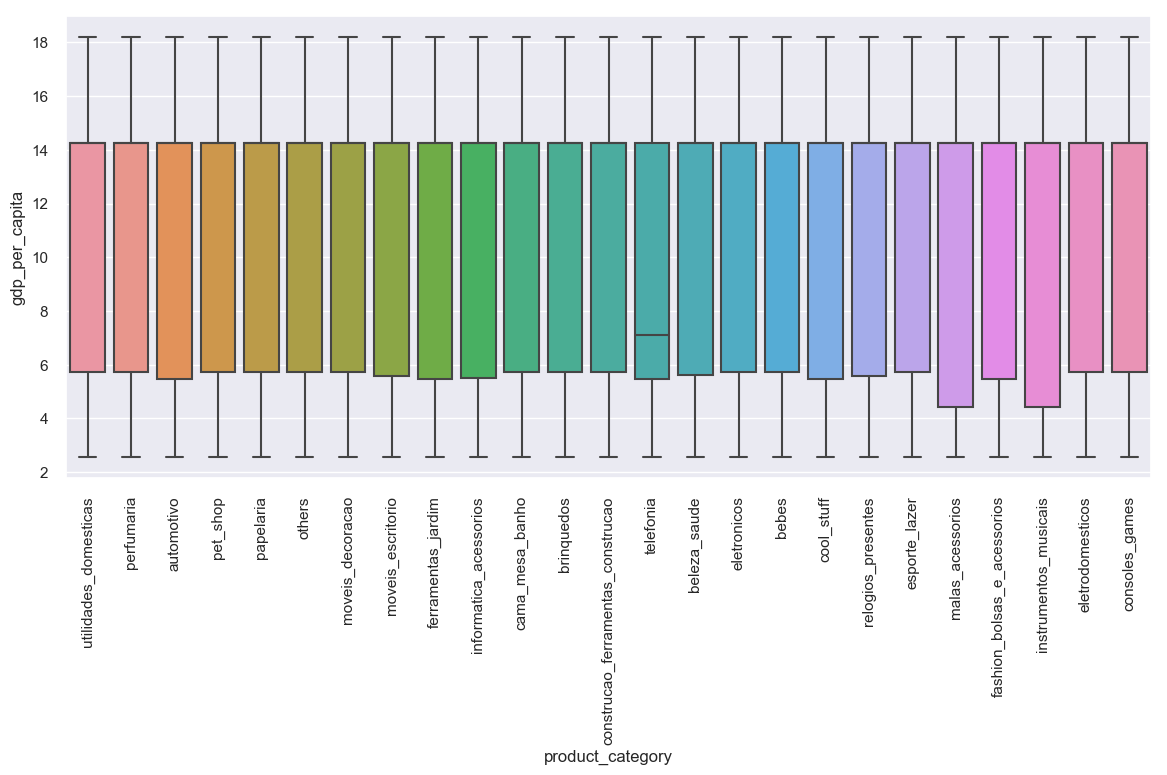

# gdp

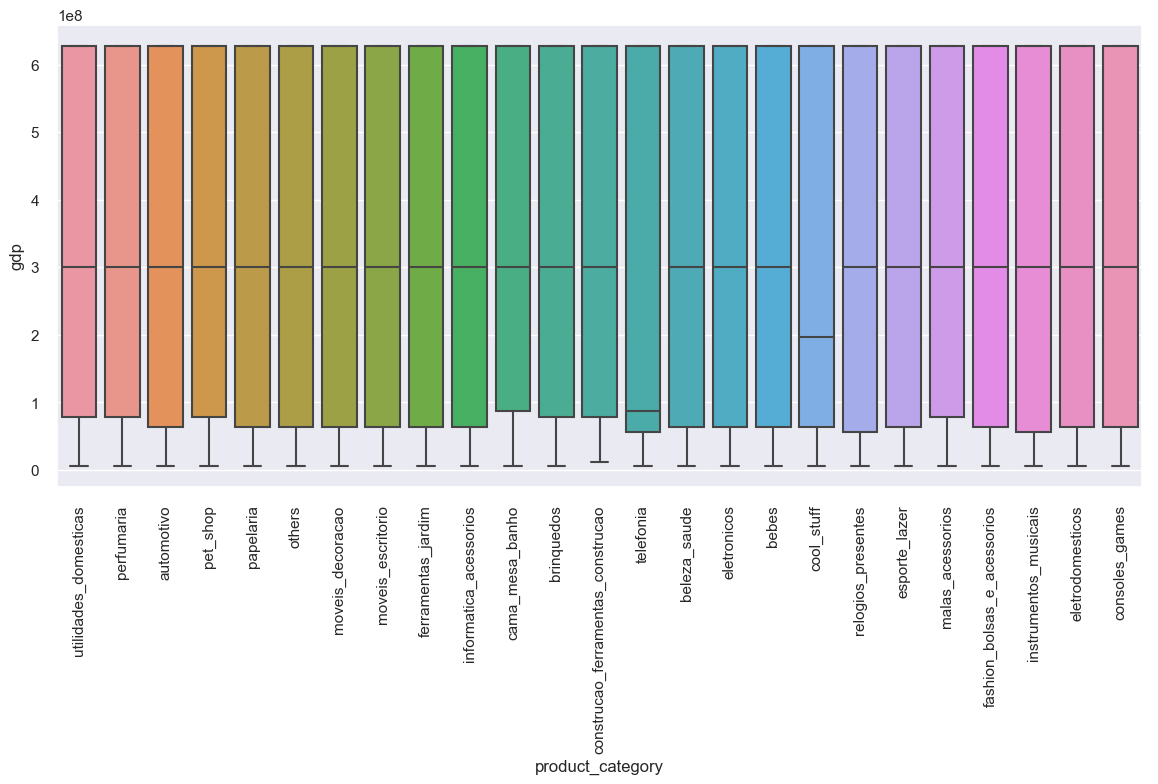

# population

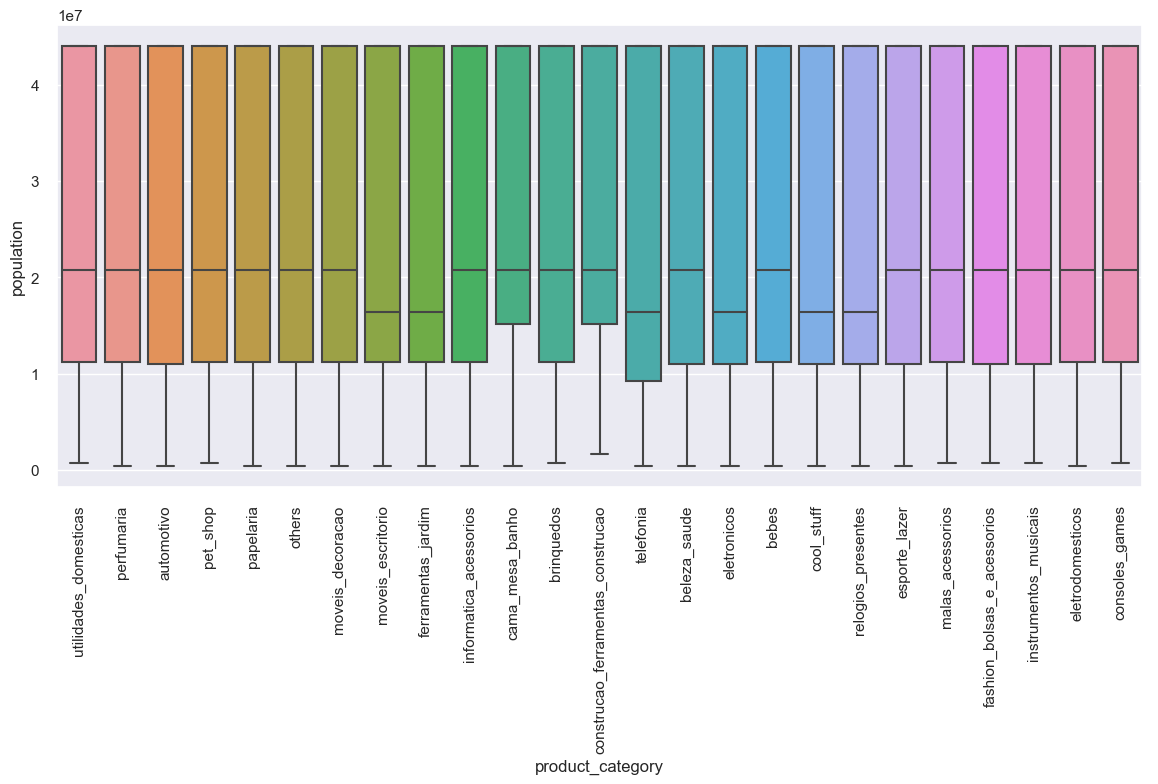

# size

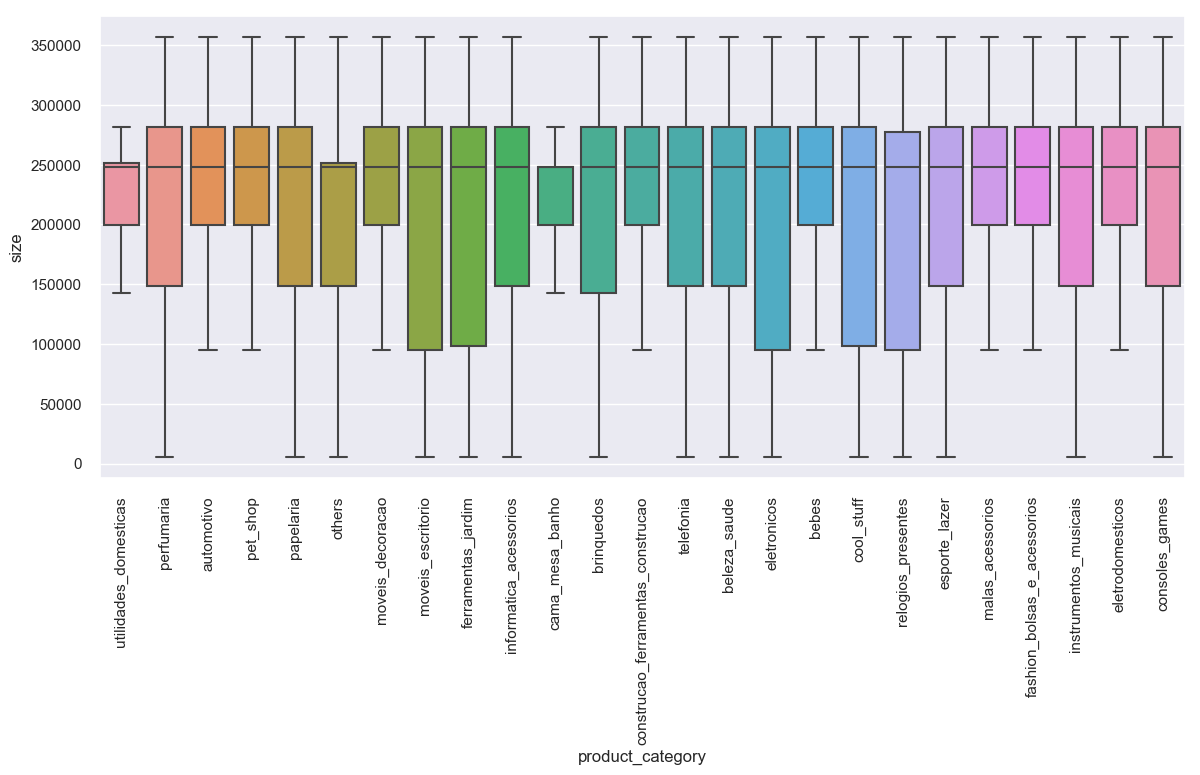

In [405]:
for col in ['gdp_per_capita', 'gdp', 'population', 'size']:
    display(Markdown("# " + col))
    sns.boxplot(subset.product_category, subset[col], showfliers=False)
    plt.xticks(rotation=90)
#     plt.yscale('log')
    plt.show()

## Analysing Return Customers

### See if demographics, purchase history and purchase experience determine the likelihood of customers returning

In [578]:
orders_filtered = orders[(orders.max_num_orders == 1) | ((orders.max_num_orders > 1) & (orders.max_num_orders > orders.customer_num_order))]

In [588]:
for month in range(1, 13):
    subset = orders_filtered[orders_filtered.month_purchase == month]
    print("Month{: 3}: {:.2f}% repeat customers".format(month, (subset.max_num_orders > 1).sum() / subset.shape[0] * 100))

Month  1: 4.26% repeat customers
Month  2: 4.65% repeat customers
Month  3: 3.70% repeat customers
Month  4: 3.15% repeat customers
Month  5: 3.50% repeat customers
Month  6: 3.19% repeat customers
Month  7: 3.59% repeat customers
Month  8: 2.97% repeat customers
Month  9: 5.50% repeat customers
Month 10: 4.46% repeat customers
Month 11: 3.99% repeat customers
Month 12: 3.44% repeat customers


C:\Users\yenter\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, '% of customers who come back later on')

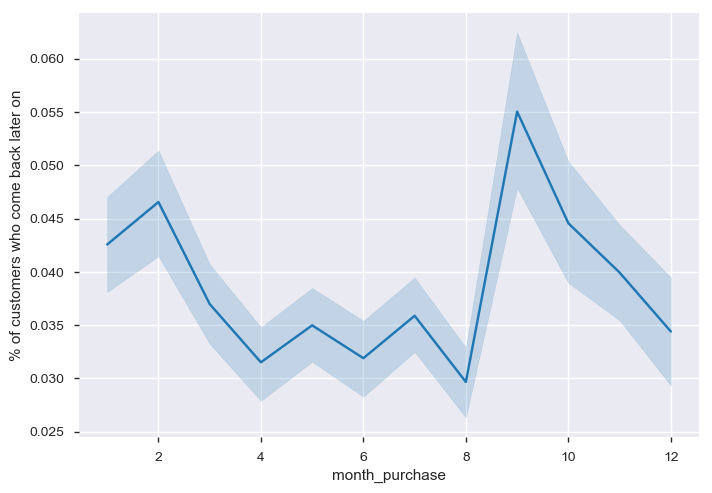

In [599]:
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1)
plt.ylabel("% of customers who come back later on")

From the above plot, we can see that there is a discernible difference in % of recurring customers for each month. 

In [679]:
# remove population (high correlation), size, gdp_per_capita, seller_id_nunique, avg_review (high p-value)

# subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
#         'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
#         'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
#         'num_reviews']]

subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
                          'size', 'gdp_per_capita', 'seller_id_nunique', 'avg_review',
                          'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
                          'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
                          'num_reviews']]


for col in subset.columns:
    if (subset[col].isna().sum() > 0) and (subset[col].dtype == float or subset[col].dtype == int):
        subset[col] = subset[col].fillna(subset[col].mean())
        
for col in ['freight_value_sum', 'freight_value_mean', 'gdp_per_capita', 'num_items', 'price_sum', 'size', 'time_to_approve']:
    if col in subset.columns:
        subset[col] = np.log1p(subset[col])

subset['y'] = subset.max_num_orders > 1
subset.drop('max_num_orders', inplace=True, axis=1)

C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [674]:
def stepwise_regression(df, y):
    selected_columns = []
    available_columns = ['gdp', 'time_to_approve', 'size', 'gdp_per_capita', 'seller_id_nunique', 'avg_review',
        'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
        'num_items', 'price_sum', 'freight_value_mean', 
        'num_reviews']
    best_score = 0
    best_pred_y = pd.Series()
    while len(selected_columns) < len(available_columns):
        col_to_add = None
        for col in available_columns:
            if col in selected_columns:
                continue
            # Build a model with each col
            X = sm.add_constant(df[selected_columns + [col]])
            model = sm.Logit(y, X).fit(disp=0)
            pred_y = round(model.predict(X))
            recall = recall_score(y, pred_y)
            if recall > best_score:
                best_score = recall
                col_to_add = col
                best_pred_y = pred_y
            
        if col_to_add is None:
            # Couldn't find anything better
            return (model, best_score, best_pred_y)
        else:
            selected_columns.append(col_to_add)
    return (model, best_score, best_pred_y)

In [680]:
model, best_score, _ = stepwise_regression(subset.drop(['y', 'month_purchase'], axis=1), subset.y)

In [681]:
best_score * 100

8.937465412285556

In [682]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                96713
Model:                          Logit   Df Residuals:                    96710
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.05706
Time:                        23:42:40   Log-Likelihood:                -14544.
converged:                       True   LL-Null:                       -15425.
                                        LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.6177      0.163    -46.779      0.000      -7.937      -7.299
num_reviews            4.6769      0.124     37.751      0.000       4.434       4.920
freight_value_mean    -0.1385      0.035     -3.933      0.000      -0.208      -0.069
======================================================================================
"""

In [600]:
# ProfileReport(subset.drop('y', axis=1))

In [683]:
true_y = pd.Series()
pred_y = pd.Series()
month_recalls = []

for month in tqdm_notebook(range(1, 13)):
    X = subset[subset.month_purchase == month].drop(['y', 'month_purchase'], axis=1)
    y = subset[subset.month_purchase == month].y
    
    model, best_score, pred_y_found = stepwise_regression(X, y)
    true_y = true_y.append(y)
    pred_y = pred_y.append(pred_y_found)
    display(Markdown("# Month " + str(month)))
    display(model.summary())
    display(Markdown("Precision: {:.3f}%".format(best_score * 100)))
    month_recalls.append(best_score * 100)

print("Precision: {: 7.3f}%".format(precision_score(true_y, pred_y) * 100))
print("Recall:    {: 7.3f}%".format(recall_score(true_y, pred_y) * 100))

# Month 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7847
Model:                          Logit   Df Residuals:                     7844
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.05617
Time:                        23:42:52   Log-Likelihood:                -1303.6
converged:                       True   LL-Null:                       -1381.1
                                        LLR p-value:                 2.019e-34
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.0087      0.586    -11.957      0.000      -8.158      -5.860
num_reviews            4.6059      0.427     10.787      0.000       3.769       5.443
freight_value_mean    -0.2789      0.141     -1.976      0.048      -0.555      -0.002
======================================================================================
"""

Precision: 8.683%

# Month 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8271
Model:                          Logit   Df Residuals:                     8268
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.09124
Time:                        23:42:52   Log-Likelihood:                -1414.8
converged:                       True   LL-Null:                       -1556.8
                                        LLR p-value:                 2.056e-62
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.5207      0.517    -14.559      0.000      -8.533      -6.508
num_reviews            4.6896      0.324     14.492      0.000       4.055       5.324
freight_value_mean    -0.1185      0.135     -0.879      0.380      -0.383       0.146
======================================================================================
"""

Precision: 14.286%

# Month 3

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9654
Model:                          Logit   Df Residuals:                     9651
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.05544
Time:                        23:42:52   Log-Likelihood:                -1442.8
converged:                       True   LL-Null:                       -1527.5
                                        LLR p-value:                 1.656e-37
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.1722      0.546    -13.131      0.000      -8.243      -6.102
num_reviews            4.5355      0.384     11.806      0.000       3.783       5.288
freight_value_mean    -0.2444      0.128     -1.914      0.056      -0.495       0.006
======================================================================================
"""

Precision: 8.683%

# Month 4

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9109
Model:                          Logit   Df Residuals:                     9106
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.02440
Time:                        23:42:53   Log-Likelihood:                -1243.6
converged:                       True   LL-Null:                       -1274.7
                                        LLR p-value:                 3.085e-14
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.3192      0.722    -11.521      0.000      -9.735      -6.904
num_reviews            4.7597      0.654      7.274      0.000       3.477       6.042
freight_value_mean     0.0329      0.103      0.320      0.749      -0.168       0.234
======================================================================================
"""

Precision: 3.833%

# Month 5

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10264
Model:                          Logit   Df Residuals:                    10261
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.04585
Time:                        23:42:53   Log-Likelihood:                -1485.0
converged:                       True   LL-Null:                       -1556.4
                                        LLR p-value:                 1.013e-31
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.2004      0.515    -15.911      0.000      -9.211      -7.190
num_reviews            4.7075      0.430     10.959      0.000       3.866       5.549
freight_value_mean     0.0355      0.091      0.391      0.696      -0.142       0.213
======================================================================================
"""

Precision: 7.242%

# Month 6

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9124
Model:                          Logit   Df Residuals:                     9121
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.04525
Time:                        23:42:53   Log-Likelihood:                -1230.6
converged:                       True   LL-Null:                       -1288.9
                                        LLR p-value:                 4.673e-26
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.3428      0.602    -12.198      0.000      -8.523      -6.163
num_reviews            4.6971      0.471      9.981      0.000       3.775       5.619
freight_value_mean    -0.2859      0.128     -2.235      0.025      -0.537      -0.035
======================================================================================
"""

Precision: 6.873%

# Month 7

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10035
Model:                          Logit   Df Residuals:                    10032
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.06878
Time:                        23:42:53   Log-Likelihood:                -1444.7
converged:                       True   LL-Null:                       -1551.4
                                        LLR p-value:                 4.559e-47
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.8187      0.516    -15.158      0.000      -8.830      -6.808
num_reviews            4.8068      0.376     12.785      0.000       4.070       5.544
freight_value_mean    -0.1322      0.114     -1.162      0.245      -0.355       0.091
======================================================================================
"""

Precision: 10.556%

# Month 8

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10519
Model:                          Logit   Df Residuals:                    10516
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.07075
Time:                        23:42:53   Log-Likelihood:                -1305.5
converged:                       True   LL-Null:                       -1404.9
                                        LLR p-value:                 6.830e-44
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -8.2375      0.578    -14.248      0.000      -9.371      -7.104
num_reviews            5.2659      0.449     11.721      0.000       4.385       6.146
freight_value_mean    -0.2166      0.123     -1.761      0.078      -0.458       0.024
======================================================================================
"""

Precision: 10.256%

# Month 9

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4179
Model:                          Logit   Df Residuals:                     4176
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.02658
Time:                        23:42:53   Log-Likelihood:                -866.83
converged:                       True   LL-Null:                       -890.49
                                        LLR p-value:                 5.270e-11
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.2544      0.662     -9.441      0.000      -7.553      -4.956
num_reviews            3.2709      0.440      7.437      0.000       2.409       4.133
freight_value_mean     0.0289      0.156      0.185      0.854      -0.278       0.336
======================================================================================
"""

Precision: 5.652%

# Month 10

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4825
Model:                          Logit   Df Residuals:                     4822
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.07339
Time:                        23:42:54   Log-Likelihood:                -814.48
converged:                       True   LL-Null:                       -878.99
                                        LLR p-value:                 9.635e-29
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.2812      0.876     -8.315      0.000      -8.997      -5.565
num_reviews            5.6584      0.749      7.557      0.000       4.191       7.126
freight_value_mean    -0.5380      0.178     -3.015      0.003      -0.888      -0.188
======================================================================================
"""

Precision: 9.767%

# Month 11

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7363
Model:                          Logit   Df Residuals:                     7360
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.06587
Time:                        23:42:54   Log-Likelihood:                -1153.6
converged:                       True   LL-Null:                       -1234.9
                                        LLR p-value:                 4.722e-36
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.2130      0.551    -13.103      0.000      -8.292      -6.134
num_reviews            4.3631      0.355     12.280      0.000       3.667       5.059
freight_value_mean    -0.1534      0.143     -1.075      0.282      -0.433       0.126
======================================================================================
"""

Precision: 10.884%

# Month 12

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5523
Model:                          Logit   Df Residuals:                     5520
Method:                           MLE   Df Model:                            2
Date:                Sun, 21 Apr 2019   Pseudo R-squ.:                 0.05508
Time:                        23:42:54   Log-Likelihood:                -781.38
converged:                       True   LL-Null:                       -826.93
                                        LLR p-value:                 1.650e-20
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -7.2779      0.840     -8.662      0.000      -8.925      -5.631
num_reviews            5.0198      0.638      7.870      0.000       3.770       6.270
freight_value_mean    -0.4067      0.191     -2.134      0.033      -0.780      -0.033
======================================================================================
"""

Precision: 7.895%


Precision:  79.361%
Recall:      8.937%


C:\Users\yenter\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


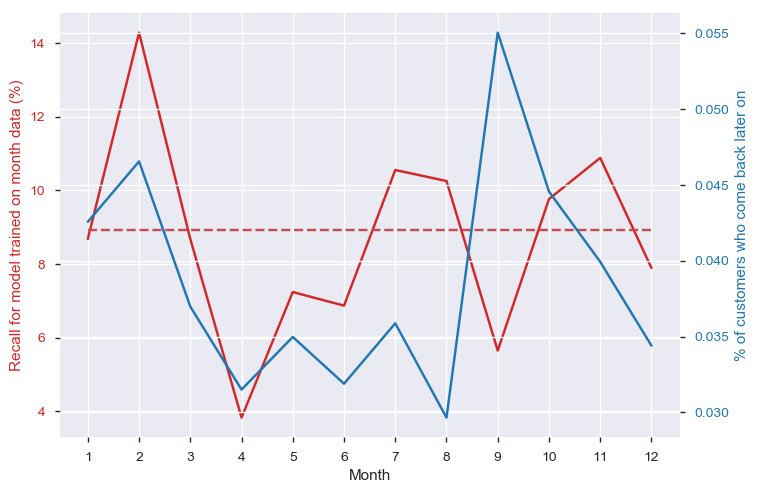

In [697]:
fig, ax1 = plt.subplots()
p = sns.lineplot(range(1, 13), month_recalls, ax=ax1, color='tab:red')
ax1.plot(range(1, 13), [recall_score(true_y, pred_y) * 100] * 12, 'r--')
ax1.set_xlabel("Month")
ax1.set_ylabel("Recall for model trained on month data (%)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
_ = plt.xticks(range(1, 13))
ax2 = ax1.twinx()
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1, err_style=None, ax=ax2, color='tab:blue')
ax2.set_ylabel("% of customers who come back later on", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Others

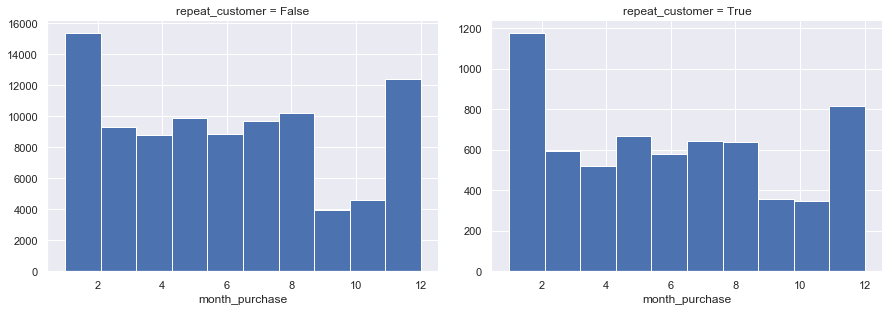

In [170]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "month_purchase")

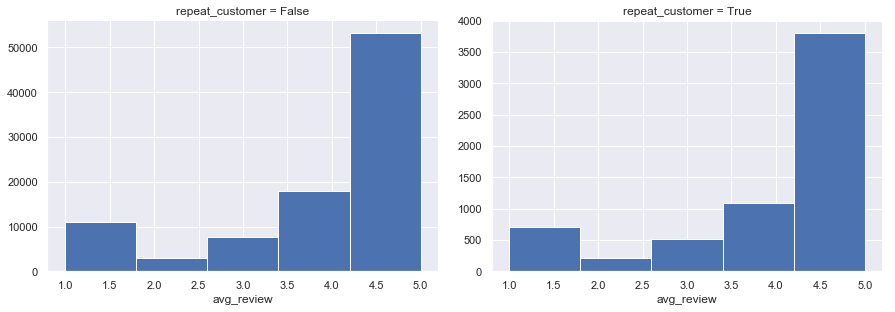

In [180]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "avg_review", bins=5)

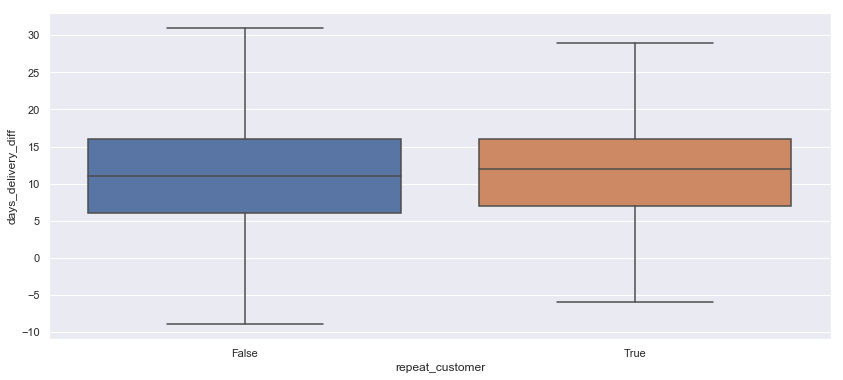

In [197]:
sns.boxplot(orders.repeat_customer, orders.days_delivery_diff, showfliers=False)

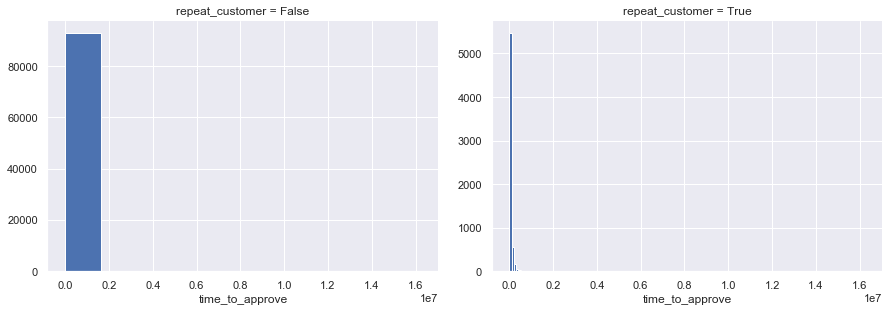

In [201]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "time_to_approve")

In [222]:
orders['time_to_approve_bins'] = pd.qcut(orders.time_to_approve, 10)

In [246]:
results = []
for category in orders['time_to_approve_bins'].cat.categories:
    sub = orders[orders.time_to_approve_bins == category]
    results.append([category, "{0:.3f}".format(sub.repeat_customer.sum() / sub.shape[0] * 100)])
print(tabulate(results, headers=('time_to_approve', '% repeat')))

time_to_approve           % repeat
----------------------  ----------
(-0.001, 605.0]              6.846
(605.0, 721.0]               6.821
(721.0, 832.0]               6.767
(832.0, 978.0]               6.12
(978.0, 1236.0]              6.471
(1236.0, 2214.0]             5.623
(2214.0, 21798.0]            6.487
(21798.0, 76783.0]           6.104
(76783.0, 124775.0]          5.852
(124775.0, 16233050.0]       6.144


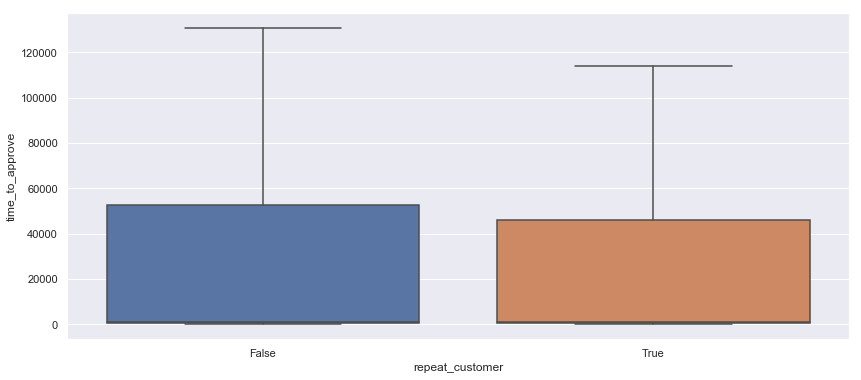

In [200]:
sns.boxplot(orders.repeat_customer, orders.time_to_approve, showfliers=False)